##### Time Series model study with monthly beer production data
Beer is made from four basic ingredients: Barley, water, hops and yeast. The basic idea is to extract the sugars from grains (usually barley) so that the yeast can turn it into alcohol and CO2, creating beer.

[![https://raw.githubusercontent.com/rabindragoswami/DataScience/master/Image/beer%20Production.jpg](https://raw.githubusercontent.com/rabindragoswami/DataScience/master/Image/beer%20Production.jpg "https://raw.githubusercontent.com/rabindragoswami/DataScience/master/Image/beer%20Production.jpg")](https://raw.githubusercontent.com/rabindragoswami/DataScience/master/Image/beer%20Production.jpg "https://raw.githubusercontent.com/rabindragoswami/DataScience/master/Image/beer%20Production.jpg")

###### About this Data Set: 
Beer Production for each month is available from 1956 till 1995 Augst. We will use this data set to preict one time series forcasting model. Eveluate the model at end and find the best suite one:

###### Steps to follow :

- Load the library
- Load the data set
- Perform Exploratory data analysis
- Analyse rolling mean, rolling standdard deviation and ADF test
- Transform the data set to make this stationary
- Fit the data set into different model
- Evaluate  the models 

#### Load  Library

In [1]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

#### Import Data

In [2]:
dataset  = pd.read_csv("https://raw.githubusercontent.com/rabindragoswami/DataScience/master/Data/monthly-beerproduction.csv")
dataset.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
Month                      476 non-null object
Monthly beer production    476 non-null float64
dtypes: float64(1), object(1)
memory usage: 7.5+ KB


In [4]:
dataset.shape

(476, 2)

In [5]:
dataset.isnull().sum()

Month                      0
Monthly beer production    0
dtype: int64

There is no null value present in data set. Lets convert the Month to date time format

In [6]:
dataset['Month'] = pd.to_datetime(dataset['Month'],infer_datetime_format = True)

In [7]:
dataset['Month'].head()

0   1956-01-01
1   1956-02-01
2   1956-03-01
3   1956-04-01
4   1956-05-01
Name: Month, dtype: datetime64[ns]

In [8]:
indexedDataset = dataset.set_index(['Month'])

In [9]:
indexedDataset.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


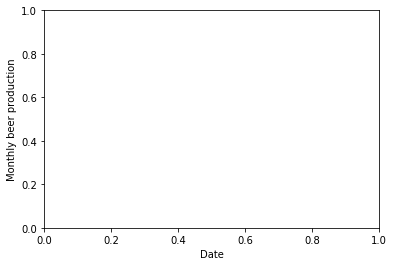

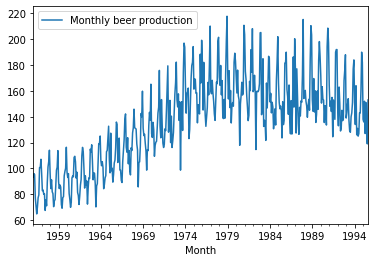

In [10]:
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']  =  15, 10
%matplotlib inline                        

plt.xlabel('Date')
plt.ylabel('Monthly beer production')
figure = indexedDataset.plot()
#figure.show()

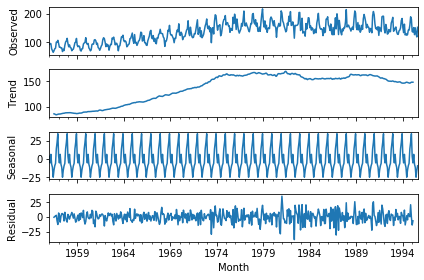

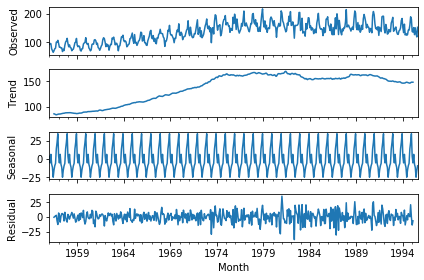

In [11]:
a = seasonal_decompose(indexedDataset["Monthly beer production"], model = "add")
a.plot()

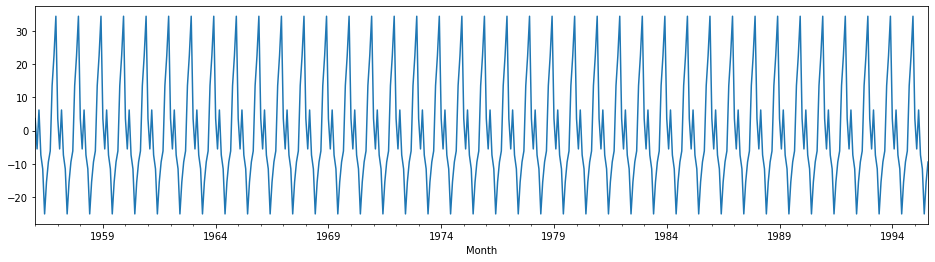

In [12]:
plt.figure(figsize = (16,4))
a.seasonal.plot()

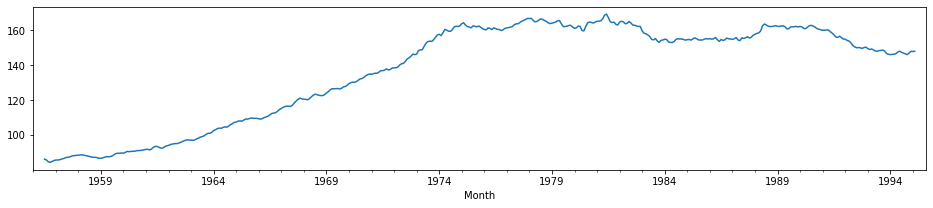

In [13]:
plt.figure(figsize = (16,3))
a.trend.plot()

Looks like the data set have trend component. It's not stationart. lets plot rolling mean and rolling sd

In [14]:
# Determine rolling statistics
def rolling_means(time_series):
    rolmean  =  time_series.rolling(window = 12).mean()    #window size 12 denotes 12 months, giving rolling mean at yearly level
    rolstd  =  time_series.rolling(window = 12).std()

    #Plot rolling statistics

    rcParams['figure.figsize']  =  10, 5 

    orig  =  plt.plot(time_series, color = 'blue', label = 'Original')
    mean  =  plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std  =  plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)

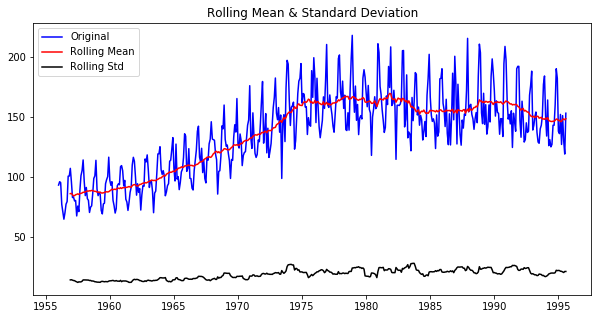

In [15]:
rolling_means(indexedDataset)

Lets perform ADF test to confirm this  with some stat value

In [16]:
#Perform Augmented Dickey–Fuller test:
def adf_test(time_series):
    from statsmodels.tsa.stattools import adfuller
    dftest  =  adfuller(time_series['Monthly beer production'], autolag = 'AIC')

    dfoutput  =  pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]  =  value
    
    print('Results of Dickey Fuller Test:')    
    print(dfoutput)

In [17]:
adf_test(indexedDataset)

Results of Dickey Fuller Test:
Test Statistic                  -2.282661
p-value                          0.177621
#Lags Used                      17.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


The data set have higher p value and critical value is higher that test statistic value. let log transfor the data.

In [18]:
indexedDataset_logScale = np.log(indexedDataset)
indexedDataset_logScale.head()

,Monthly beer production
Month,
1956-01-01,4.534748
1956-02-01,4.564348
1956-03-01,4.555980
1956-04-01,4.345103
1956-05-01,4.261270


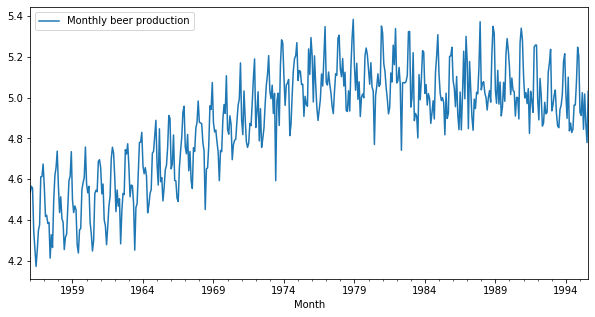

In [19]:
indexedDataset_logScale.plot()

In [20]:
adf_test(indexedDataset_logScale)

Results of Dickey Fuller Test:
Test Statistic                  -2.800769
p-value                          0.058164
#Lags Used                      17.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


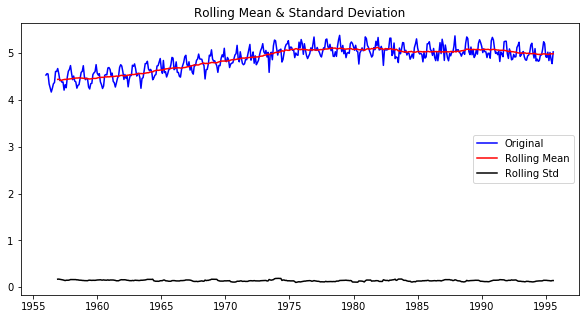

In [21]:
rolling_means(indexedDataset_logScale)

log transform do not have much impact . The data set still not stationary. lets do anoth round of transform

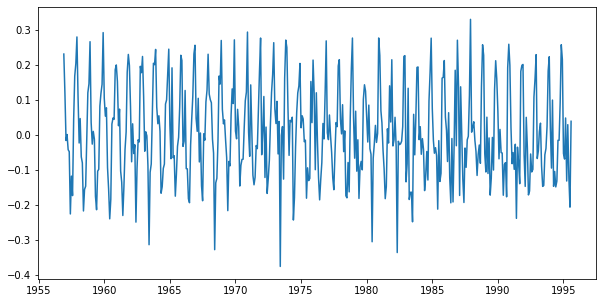

In [22]:
movingAverage  =  indexedDataset_logScale.rolling(window = 12).mean()
datasetLogScaleMinusMovingAverage  =  indexedDataset_logScale - movingAverage
plt.plot(datasetLogScaleMinusMovingAverage)

In [23]:
datasetLogScaleMinusMovingAverage.isna().sum()

Monthly beer production    11
dtype: int64

In [24]:
datasetLogScaleMinusMovingAverage.dropna(inplace=True)

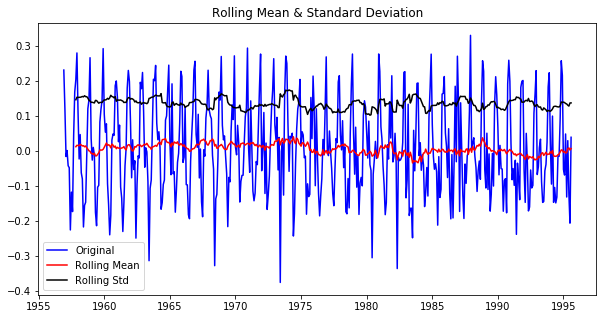

In [25]:
rolling_means(datasetLogScaleMinusMovingAverage)

In [26]:
adf_test(datasetLogScaleMinusMovingAverage)

Results of Dickey Fuller Test:
Test Statistic                  -3.432559
p-value                          0.009898
#Lags Used                      13.000000
Number of Observations Used    451.000000
Critical Value (1%)             -3.444933
Critical Value (5%)             -2.867970
Critical Value (10%)            -2.570195
dtype: float64


This transformed data set looks good with very nominal P value and Test Statistic values is less that 5 % and 10 % 
critical value. Rolling mean and rolling Std is near to parallel to X axis. So this data set is very close to stationary
##### We will use this transformed data set to Train and Test the model.
###### Lets SPlit the data set to train and test

In [27]:
datasetLogScaleMinusMovingAverage.shape

(465, 1)

In [28]:
# Data Preparation
train, test = datasetLogScaleMinusMovingAverage[1:len(datasetLogScaleMinusMovingAverage)-12], datasetLogScaleMinusMovingAverage[len(datasetLogScaleMinusMovingAverage)-12:]


In [29]:
train.shape


(452, 1)

In [30]:
test.shape

(12, 1)

## AR Model

In [31]:
from statsmodels.tsa.ar_model import AR
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 17
Coefficients: const                          0.003803
L1.Monthly beer production    -0.103270
L2.Monthly beer production    -0.167403
L3.Monthly beer production    -0.053037
L4.Monthly beer production    -0.120097
L5.Monthly beer production     0.063904
L6.Monthly beer production    -0.173682
L7.Monthly beer production    -0.093954
L8.Monthly beer production    -0.006670
L9.Monthly beer production    -0.021979
L10.Monthly beer production   -0.140492
L11.Monthly beer production    0.195603
L12.Monthly beer production    0.599437
L13.Monthly beer production    0.110957
L14.Monthly beer production    0.180858
L15.Monthly beer production    0.017844
L16.Monthly beer production   -0.046030
L17.Monthly beer production    0.041610
dtype: float64


In [32]:
# make predictions
AR_predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
AR_predictions.head()

1994-09-01   -0.048421
1994-10-01    0.051313
1994-11-01    0.193552
1994-12-01    0.177764
1995-01-01    0.033052
Freq: MS, dtype: float64

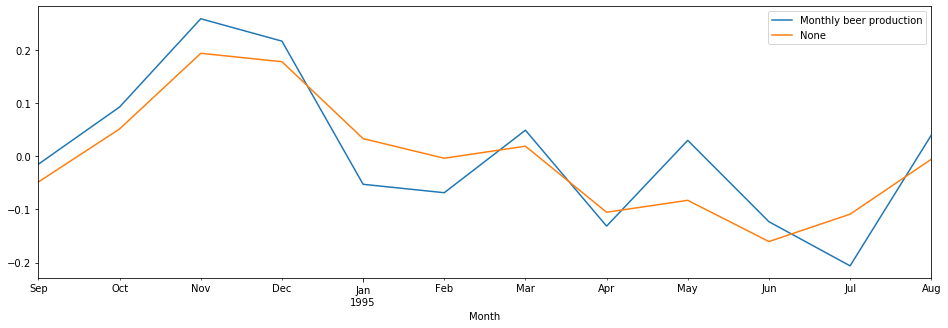

In [33]:
test['Monthly beer production'].plot(figsize = (16,5), legend=True)
AR_predictions.plot(legend = True);

#### Model Evaluation

In [34]:
ar_rmse_error = rmse(test['Monthly beer production'], AR_predictions)
ar_mse_error = ar_rmse_error**2
mean_value = datasetLogScaleMinusMovingAverage['Monthly beer production'].mean()

print(f'MSE Error: {ar_mse_error}\nRMSE Error: {ar_rmse_error}\nMean: {mean_value}')

MSE Error: 0.003940954533855447
RMSE Error: 0.06277702233982946
Mean: 0.006231951814286057


## ARIMA Model

In [35]:
arima_model = SARIMAX(train['Monthly beer production'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:            Monthly beer production   No. Observations:                  452
Model:             SARIMAX(2, 1, 1)x(4, 0, 3, 12)   Log Likelihood                 605.512
Date:                            Mon, 27 Jan 2020   AIC                          -1189.024
Time:                                    01:02:17   BIC                          -1143.798
Sample:                                01-01-1957   HQIC                         -1171.201
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1783      0.041     -4.361      0.000      -0.258      -0.098
ar.L2         -0.1199      0.011    -10.632      0.000      -0.142      -0.098
ma.L1         -0.9835      0.010    -98.450      0.000      -1.003      -0.964
ar.S.L12       1.0614      0.476      2.229      0.026       0.128       1.995
ar.S.L24       0.6656      0.953      0.699      0.485      -1.201       2.533
ar.S.L36      -0.9822      0.644     -1.525      0.127      -2.245       0.280
ar.S.L48       0.2511      0.161      1.556      0.120      -0.065       0.567
ma.S.L12      -0.7698      0.479     -1.607      0.108      -1.709       0.169
ma.S.L24      -0.8829      0.812     -1.087      0.277      -2.475       0.709
ma.S.L36       0.7853      0.388      2.026      0.043       0.025       1.545
sigma2         0.0037      0.000     17.297      0.000       0.003       0.004
===================================================================================
Ljung-Box (Q):                      152.86   Jarque-Bera (JB):                31.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# make predictions
ARIMA_predictions = arima_result.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ARIMA_predictions.head()

1994-09-01   -0.081029
1994-10-01    0.090931
1994-11-01    0.171052
1994-12-01    0.218609
1995-01-01    0.014526
Freq: MS, dtype: float64

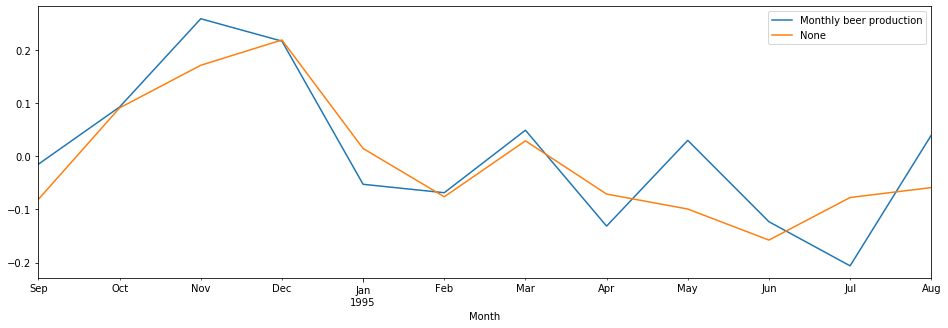

In [37]:
test['Monthly beer production'].plot(figsize = (16,5), legend=True)
ARIMA_predictions.plot(legend = True);

In [38]:
arima_rmse_error = rmse(test['Monthly beer production'], ARIMA_predictions)
arima_mse_error = arima_rmse_error**2
mean_value = datasetLogScaleMinusMovingAverage['Monthly beer production'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 0.005396033477032394
RMSE Error: 0.07345769855523922
Mean: 0.006231951814286057


In [42]:
arima_result.fittedvalues.head()

Month
1957-01-01    0.000000
1957-02-01    0.118994
1957-03-01    0.055639
1957-04-01    0.045764
1957-05-01    0.025311
dtype: float64

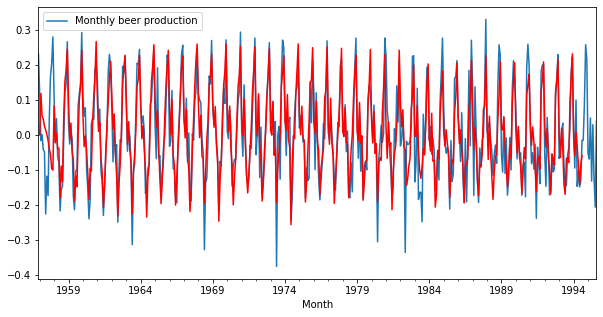

In [43]:
datasetLogScaleMinusMovingAverage.plot()
arima_result.fittedvalues.plot(color='red')

### Prediction & Reverse transformations of fittedvalues 

In [45]:
predictions_ARIMA_diff = pd.Series(arima_result.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1957-01-01    0.000000
1957-02-01    0.118994
1957-03-01    0.055639
1957-04-01    0.045764
1957-05-01    0.025311
dtype: float64

In [46]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1957-01-01    0.000000
1957-02-01    0.118994
1957-03-01    0.174632
1957-04-01    0.220396
1957-05-01    0.245707
dtype: float64

In [65]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Monthly beer production'].iloc[0], index=datasetLogScaleMinusMovingAverage.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1956-12-01    4.534748
1957-01-01    4.534748
1957-02-01    4.653741
1957-03-01    4.709380
1957-04-01    4.755144
dtype: float64

In [57]:
reverted_back_prediction = pd.DataFrame(np.exp(predictions_ARIMA_log))
reverted_back_prediction.head()

,0
Month,
1956-12-01,153.000000
1957-01-01,153.000000
1957-02-01,172.333499
1957-03-01,182.193653
1957-04-01,190.725277


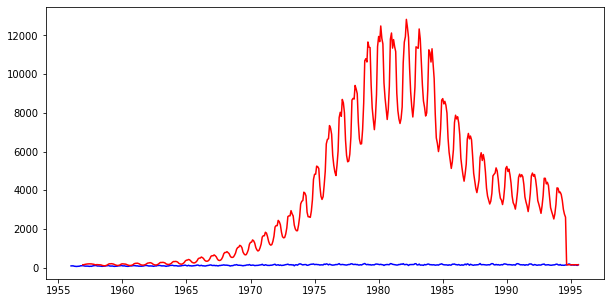

In [63]:
from matplotlib import pyplot
pyplot.plot(indexedDataset,color='blue')
pyplot.plot(reverted_back_prediction, color='red')
pyplot.show()

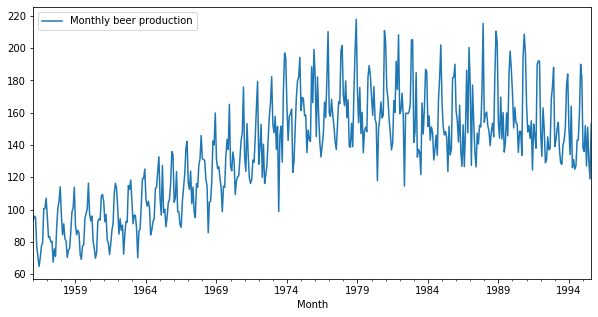

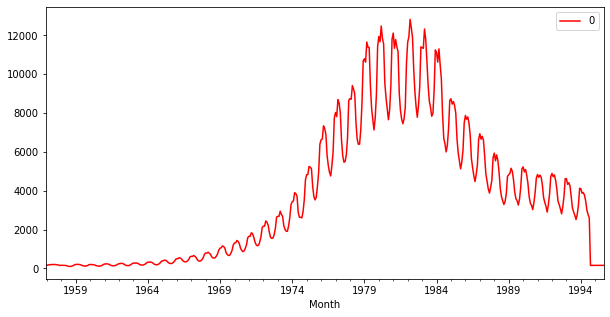

In [64]:
indexedDataset.plot()
reverted_back_prediction.plot(color='red')